In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device="cpu"

In [3]:
class Diff_Hist(nn.Module):
    def __init__(self, centers=[-5, -2.5, 0, 2.5, 5], scale=2):
        super(Diff_Hist, self).__init__()
        """ centers: center of the bins used. 
            scale  : exponential scale for sigmoid. the higher,
                the lower the amplitud of the bins.
        """
        # save params
        self.scale        = scale
        self.true_centers = centers
        self.max_scaler   = 1
        self.max_scaler   = torch.max(self.func(torch.arange(start=-1, end=1, step=1e-3)))
        # our function is centered @ 0.5 by default
        self.centers      = 0.5 + np.array(self.true_centers)

    def forward(self, x, batch=None, bsize=None):
        r""" reduces dim=0 as a set of bins. designed for 2d outs. """
        out = torch.zeros(len(self.centers), *x.shape[1:], device=device)
        for i, center in enumerate(self.centers):
            out[i]  = self.make_bin(x, center)
        return out / x.shape[0]

    def make_bin(self, x, center):
        return self.func(x+center).sum(dim=0, keepdim=True)
        
    def func(self, x):
        # augmenting sigmoid so higher gradient and localized feats
        sigmoid_x = lambda y: 1/(1+torch.exp(-self.scale*y))
        # perfrom minmax scaling so max is 1 and min (is already) 0
        return (sigmoid_x(x)-sigmoid_x(x-1))/self.max_scaler

    def __repr__(self):
        return "Simple differentiable histogram layer:" + \
               str({"centers"   : self.true_centers,
                    "exp_scale" : self.scale})

In [4]:
class Readout_Hist(nn.Module):
    def __init__(self, centers):
        super(Readout_Hist, self).__init__()
        # save centers
        self.true_centers = centers
        self.diff_hist    = Diff_Hist(centers=centers)

    def forward(self, x, batch=None, bsize=None, dim=0):
        r""" reduces dim=0 as a set of bins. designed for 2d outs. """
        bsize = bsize if bsize is not None else int(torch.max(batch).cpu().numpy())+1
        out   = torch.empty(bsize, len(self.true_centers), *x.shape[1:], device=device)
        # for all unique nodes
        for n in range(bsize):
            # create a multi-center hist for their feats
            out[n]  = self.diff_hist(x[batch==n])
        return out.reshape(out.shape[0], -1)

    def __repr__(self):
        return "Readout by histogram:" + str({"centers": self.true_centers})

In [5]:
offset, n = 2, 5
centers = list(range(-offset*n, offset*n+1))
hister  = Diff_Hist(centers=centers)#[-8,-6,-4,-2,0,2,4,6,8])

(tensor([[9.0638e-08, 7.3836e-08, 5.7620e-08, 7.7909e-08, 7.2542e-08],
         [6.6972e-07, 5.4558e-07, 4.2576e-07, 5.7567e-07, 5.3601e-07],
         [4.9485e-06, 4.0312e-06, 3.1459e-06, 4.2536e-06, 3.9604e-06],
         [3.6555e-05, 2.9782e-05, 2.3241e-05, 3.1427e-05, 2.9254e-05],
         [2.6959e-04, 2.1980e-04, 1.7153e-04, 2.3202e-04, 2.1563e-04],
         [1.9647e-03, 1.6099e-03, 1.2567e-03, 1.7040e-03, 1.5654e-03],
         [1.3262e-02, 1.1199e-02, 8.7658e-03, 1.2061e-02, 1.0324e-02],
         [6.6803e-02, 6.1105e-02, 4.9494e-02, 6.9827e-02, 4.9306e-02],
         [2.2094e-01, 2.1431e-01, 1.9192e-01, 2.4261e-01, 1.8085e-01],
         [5.0562e-01, 4.5883e-01, 4.6162e-01, 4.9892e-01, 4.7481e-01],
         [6.3941e-01, 5.8921e-01, 6.5953e-01, 6.1954e-01, 6.5723e-01],
         [4.4632e-01, 4.8565e-01, 5.0412e-01, 4.5916e-01, 4.9883e-01],
         [1.9485e-01, 2.3998e-01, 2.2169e-01, 2.0439e-01, 2.2193e-01],
         [5.9244e-02, 8.0523e-02, 5.5151e-02, 4.7137e-02, 5.7686e-02],
      

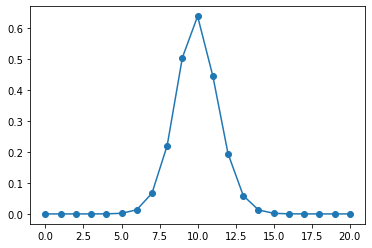

In [6]:
inputs = torch.randn(87,5)
# plot and print()
plt.plot(hister(inputs)[:, 0].flatten(), "o-")
hister(inputs), hister


In [7]:
%%timeit
# timing - only the histogram, not the readout
for i in range(10):
    histed = hister(inputs)

15 ms ± 216 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
